In [1]:
# Preparation of the Dataset and Dataloaders

# Import necessary libraries
import os
import csv
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
from PIL import Image

# Function to get data transformations for training and validation datasets
def get_transforms():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([224, 224]),  # Resize images to 224x224
            transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
            transforms.RandomRotation(15),  # Apply random rotation
            transforms.ToTensor(),  # Convert image to tensor
        ]),
        'val': transforms.Compose([
            transforms.Resize([224, 224]),  # Resize images to 224x224
            transforms.ToTensor(),  # Convert image to tensor
        ]),
    }
    return data_transforms

# Custom Dataset class for shape images
class ShapeDataset(Dataset):
    def __init__(self, transform=None):
        # Read the CSV file containing shape counts
        with open('shape_counts.csv', 'r') as f:
            self.data = []
            csv_reader = csv.reader(f, delimiter=',')
            for row in csv_reader:
                self.data.append(row)

        # Remove header row
        self.data.pop(0)

        # Store the transform to apply on images
        self.transform = transform

    def __len__(self):
        return len(self.data)  # Return the number of samples

    def __getitem__(self, idx):
        # Get the filename and load the image
        filename = self.data[idx][0]
        image = Image.open(filename)

        # Convert image to RGB if not already in RGB mode
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply the transformation if specified
        if self.transform is not None:
            image = self.transform(image)

        # Return the image and the labels (normalized)
        return image, torch.tensor([int(self.data[idx][1])/3, int(self.data[idx][2])/3, int(self.data[idx][3])/3])

# Function to create dataloaders for training and validation
def get_dataloaders(val_rate=0.2):
    generator = torch.Generator().manual_seed(561371)  # Set the random seed for reproducibility
    data_transforms = get_transforms()  # Get data transformations
    dataset_full = ShapeDataset()  # Create the full dataset
    dataset_train, dataset_val = random_split(dataset_full, [1 - val_rate, val_rate], generator=generator)  # Split the dataset
    dataset_train.dataset.transform = data_transforms['train']  # Apply train transformations
    dataset_val.dataset.transform = data_transforms['val']  # Apply validation transformations
    dataloaders = {'train': DataLoader(dataset_train, batch_size=32, shuffle=True),  # Create train dataloader
                   'val': DataLoader(dataset_val, batch_size=32, shuffle=False)}  # Create validation dataloader
    return dataloaders

tensor([0.0000, 0.3333, 0.6667])


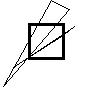

In [2]:
# Dataset Inspection
dataset = ShapeDataset()  # Create an instance of the ShapeDataset
print(dataset[8][1])  # Print the labels of the 9th sample
dataset[8][0]  # Display the 9th sample image


In [3]:
# Model Training Function

# Import necessary libraries
import copy
import os
import time

import torch
from torch import nn
from tqdm import tqdm

# Define the training function
def train(
        model: nn.Module,  # The neural network model to be trained
        dataloaders: dict,  # Dictionary containing dataloaders for 'train' and 'val' phases
        optimizer,  # Optimizer to update the model weights
        criterion,  # Loss function to optimize
        scheduler,  # Learning rate scheduler to adjust the learning rate
        device,  # Device on which to perform computations (CPU or GPU)
        run_name: str,  # Name for this training run (used for saving model weights)
        num_epochs: int = 10):  # Number of epochs to train the model

    # Create the directory to save model weights if it doesn't exist
    os.makedirs('./weights', exist_ok=True)

    # Record the start time of training
    since = time.time()

    # Get the sizes of the training and validation datasets
    dataset_sizes = {phase: len(dl.dataset) for phase, dl in dataloaders.items()}
    # Make a deep copy of the model's initial weights (best model weights)
    best_model_wts = copy.deepcopy(model.state_dict())
    # Initialize the best loss to a very large number
    best_loss = 1_000_000.

    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Flag to break the loop if needed
    flag_loop = True

    # Loop over the epochs
    for epoch in range(num_epochs):
        if not flag_loop:
            break
        # Loop over the phases (training and validation)
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set the model to training mode
                model.train()
            else:
                # Set the model to evaluation mode
                model.eval()

            # Initialize the running loss and number of samples
            running_loss = 0.0
            running_samples = 0

            # Create a progress bar for the current phase
            pbar = tqdm(dataloaders[phase], desc=f'{phase:6} - Epoch {epoch:3}/{num_epochs:3}', unit=' batch')
            for inputs, labels in pbar:
                # Move inputs to the device (CPU or GPU)
                inputs = inputs.to(device)
                # Update the number of processed samples
                running_samples += inputs.size(0)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass: compute outputs and loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.cpu()
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update the running loss
                running_loss += loss.item() * inputs.size(0)

                # Update the progress bar with the current loss
                pbar.set_postfix(loss=running_loss / running_samples)

            # Step the learning rate scheduler in the validation phase
            if phase == 'val':
                scheduler.step(running_loss)

            # Calculate the epoch loss
            epoch_loss = running_loss / dataset_sizes[phase]

            # Update the best model weights if validation loss has improved
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model weights
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                }, f'weights/{run_name}_best_model.pt')
            pbar.close()

    # Calculate the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
# Model Definition

# Import torchvision
import torchvision

# Define a custom ResNet model
class MyResnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pre-trained ResNet18 model
        self.res = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        # Replace the fully connected layer to output 3 values
        self.res.fc = torch.nn.Sequential(
            torch.nn.Linear(self.res.fc.in_features, 3),
            torch.nn.ReLU()
        )

    def forward(self, x):
        out = self.res(x)  # Forward pass through the ResNet18 model
        return out


In [5]:
# Model Training
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is {device}')

model = MyResnet()  # Initialize the custom ResNet model
dataloaders = get_dataloaders()  # Get dataloaders

# Define the loss function, optimizer, and learning rate scheduler
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-2)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5)

# Train the model
classification_model_best = train(
    model=model,
    dataloaders=dataloaders,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=lr_scheduler,
    device=device,
    run_name='multiclass_res',
    num_epochs=500)

Device is cuda


val    - Epoch 499/500: 100%|██████████████████████████████████████████| 7/7 [00:00<00:00, 18.43 batch/s, loss=0.00634]

Training complete in 18m 10s
Best val loss: 0.004900042116641998


In [9]:
# Model Evaluation

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloaders = get_dataloaders()  # Get dataloaders
model = MyResnet()  # Initialize the custom ResNet model
# Load the best model weights
model.load_state_dict(torch.load('weights/multiclass_res_best_model.pt')['model_state_dict'])
model.to(device)  # Move the model to the device
model.eval()  # Set the model to evaluation mode

# Initialize lists to store predictions and labels
preds = []
labels = []

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, label in tqdm(dataloaders['val']):
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = outputs.cpu()
        labels.extend((label*3).tolist())
        preds.extend(torch.round(outputs*3).tolist())

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.78it/s]


In [11]:
# Evaluation Metrics

# Import necessary library
import numpy as np

# Calculate the percentage of samples where all 3 coordinates match exactly
matched_3 = ((np.asarray(labels) == np.asarray(preds)).sum(axis=1) == 3).mean() * 100
# Calculate the percentage of samples where at least 2 out of 3 coordinates match
matched_2 = ((np.asarray(labels) == np.asarray(preds)).sum(axis=1) >= 2).mean() * 100
# Calculate the percentage of samples where at least 1 out of 3 coordinates match
matched_1 = ((np.asarray(labels) == np.asarray(preds)).sum(axis=1) >= 1).mean() * 100

# Print the percentage of exact matches for all 3, at least 2, and at least 1 coordinates
print(matched_3, matched_2, matched_1)

# all match - least 2 out of 3 match - least 1 out of 3 match

87.0 98.5 100.0
